In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# Set a random seed for reproducibility
np.random.seed(0)
# Load your  dataset with columns
df = pd.read_csv(r"C:\Users\71589\Desktop\MLTempDataset.csv")

df = df.drop(columns=["Unnamed: 0", "Datetime1"])

df

,DAYTON_MW,Datetime
0,20.87,2022-01-04 00:00:00
1,21.00,2022-01-04 01:00:00
2,20.87,2022-01-04 02:00:00
3,20.65,2022-01-04 03:00:00
4,20.40,2022-01-04 04:00:00
...,...,...
6671,27.35,2022-10-08 23:00:00
6672,26.80,2022-10-09 00:00:00
6673,26.45,2022-10-09 01:00:00
6674,25.90,2022-10-09 02:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DAYTON_MW  6676 non-null   float64
 1   Datetime   6676 non-null   object 
dtypes: float64(1), object(1)
memory usage: 104.4+ KB


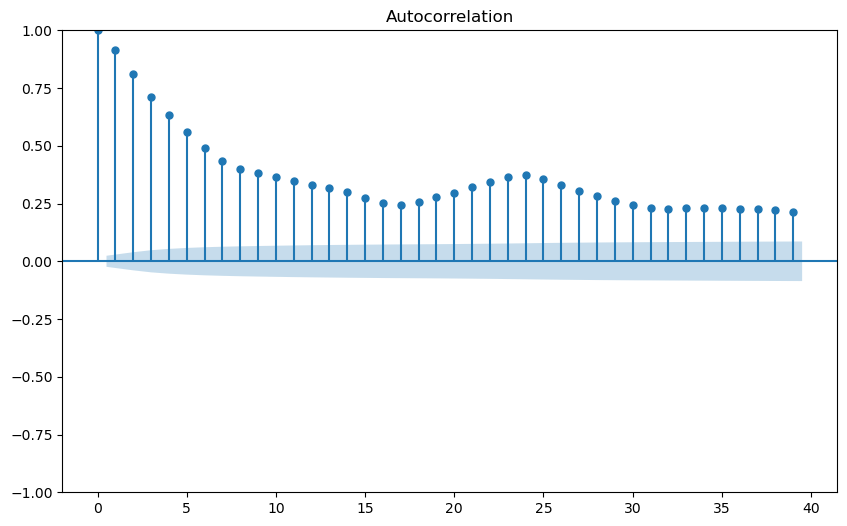

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
series = df['DAYTON_MW'] # Extract the 'TouristNumber' series from the DataFrame
plot_acf(series) # Plot the autocorrelation function (ACF) to visualize how the series correlates with its lagged versions
plt.show()


In [7]:
df['Datetime'] = pd.to_datetime(df['Datetime'])


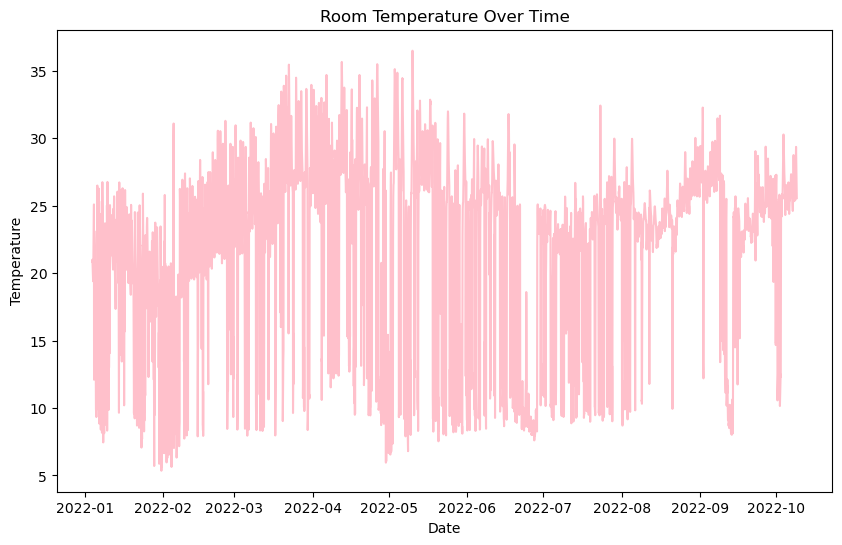

In [8]:
# Assuming 'df' has a datetime index and a 'DAYTON_MW' column
sns.lineplot(data=df, x='Datetime', y='DAYTON_MW', color='pink')

# Add title and labels
plt.title('Room Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Show the plot
plt.show()

In [9]:
print("Initial DataFrame:")
print(df)

Initial DataFrame:
      DAYTON_MW            Datetime
0         20.87 2022-01-04 00:00:00
1         21.00 2022-01-04 01:00:00
2         20.87 2022-01-04 02:00:00
3         20.65 2022-01-04 03:00:00
4         20.40 2022-01-04 04:00:00
...         ...                 ...
6671      27.35 2022-10-08 23:00:00
6672      26.80 2022-10-09 00:00:00
6673      26.45 2022-10-09 01:00:00
6674      25.90 2022-10-09 02:00:00
6675      25.57 2022-10-09 03:00:00

[6676 rows x 2 columns]


In [10]:
# Define the size of the training set as 80% of the total dataset

train_size = int(0.8 * len(df))

# Split the dataset into training and testing sets
# The training set consists of the first 80% of the data
train_data = df[:train_size]
# The testing set consists of the remaining 20% of the data
test_data = df[train_size:]


In [11]:
# Reset the index of the training data and select the 'Datetime' and 'DAYTON_MW' columns

train_df = train_data.reset_index()[['Datetime', 'DAYTON_MW']]
# Rename the selected columns to 'ds' and 'y' respectively,
# typically used for compatibility with time series forecasting models like Facebook Prophet
train_df.columns = ['ds', 'y']

In [12]:
# Reset the index of the test data and select the 'Datetime' and 'DAYTON_MW' columns
test_df = test_data.reset_index()[['Datetime', 'DAYTON_MW']]
# Rename the selected columns to 'ds' and 'y' respectively,
# typically used for compatibility with time series forecasting models like Facebook Prophet
test_df.columns = ['ds', 'y']

In [13]:
test_df

,ds,y
0,2022-08-14 12:00:00,23.70
1,2022-08-14 13:00:00,23.63
2,2022-08-14 14:00:00,23.47
3,2022-08-14 15:00:00,23.20
4,2022-08-14 16:00:00,23.15
...,...,...
1331,2022-10-08 23:00:00,27.35
1332,2022-10-09 00:00:00,26.80
1333,2022-10-09 01:00:00,26.45
1334,2022-10-09 02:00:00,25.90


In [14]:
# Initialize the Prophet model with daily and yearly seasonality components
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
# Fit the Prophet model to the training data
model.fit(train_df)

15:08:49 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Create future dataframe for 365 hours into the future
future = model.make_future_dataframe(periods=len(test_df), freq='H')


In [16]:
# Make predictions using the future dataframe
forecast = model.predict(future)


In [17]:
# Review the forecast

# Display the forecast results
# The forecast DataFrame includes the following columns:
# 'ds' - the datetime for the forecasted values
# 'yhat' - the predicted value
# 'yhat_lower' - the lower bound of the predicted value (uncertainty interval)
# 'yhat_upper' - the upper bound of the predicted value (uncertainty interval)
# The .tail() method is used to print the last few rows of the DataFrame

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                      ds  yhat  yhat_lower  yhat_upper
6671 2022-10-08 23:00:00 25.44       17.40       33.90
6672 2022-10-09 00:00:00 24.64       16.33       32.55
6673 2022-10-09 01:00:00 23.96       16.19       32.15
6674 2022-10-09 02:00:00 23.51       15.20       31.81
6675 2022-10-09 03:00:00 23.21       15.19       31.76


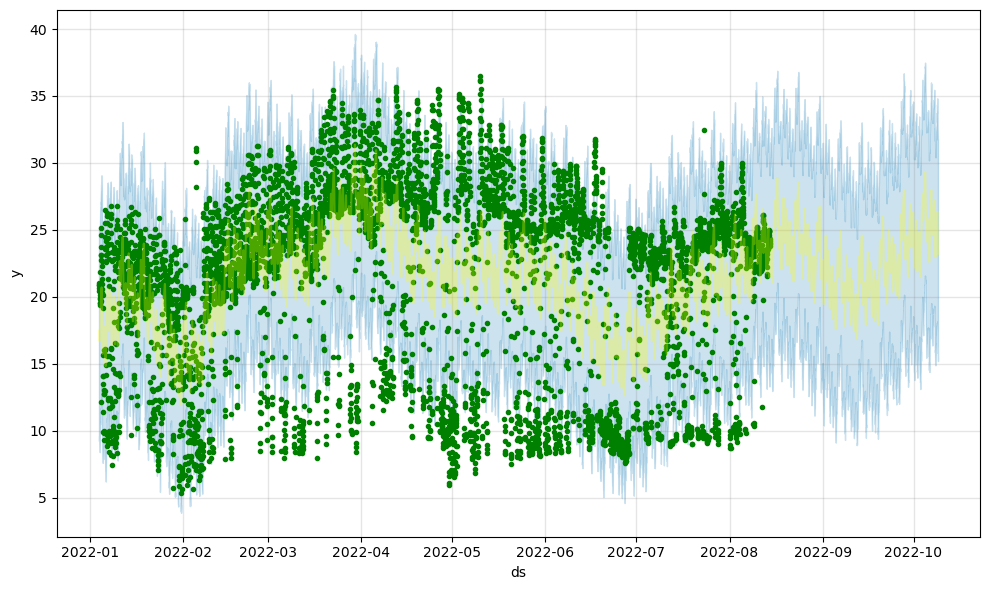

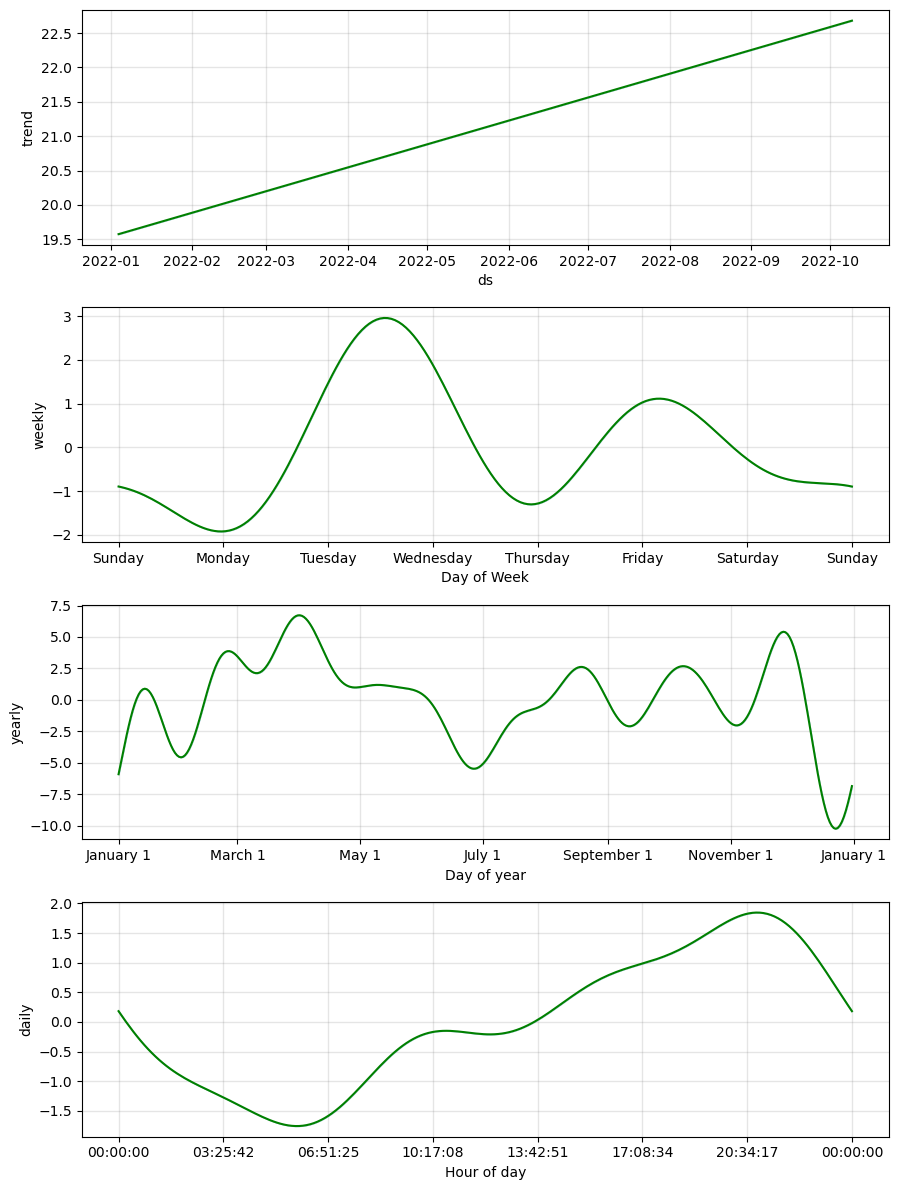

In [18]:
# Plot the forecast
fig1 = model.plot(forecast)
# Change the color of the forecast line to green and the confidence interval to yellow
ax1 = fig1.gca()
lines = ax1.get_lines()
lines[0].set_color('green')  # Change the color of the forecast line to green
for line in lines[1:]:  # Change the color of the confidence intervals to yellow
    line.set_alpha(0.3)  # Make confidence intervals more transparent
    line.set_color('yellow')

# Plot the forecast components (trend, yearly seasonality, etc.)
fig2 = model.plot_components(forecast)
# Change the color of the components
components = fig2.get_axes()
for ax in components:
    lines = ax.get_lines()
    for line in lines:
        line.set_color('green')  # Change the color of the components to green

plt.show()

In [46]:
test_df.shape[0]

1336

In [47]:
# Create a DataFrame for the future dates corresponding to the test period
# This DataFrame only includes the 'ds' (datetime) column from the test data future_test = test_df[['ds']].copy()
future_test = test_df[['ds']].copy()
# Make predictions
forecast_test = model.predict(future_test)

# Extract predictions
y_pred = forecast_test['yhat'].values
y_test = test_df['y'].values

In [48]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Absolute Error: 3.67
Root Mean Squared Error: 4.88
R-squared: -0.14


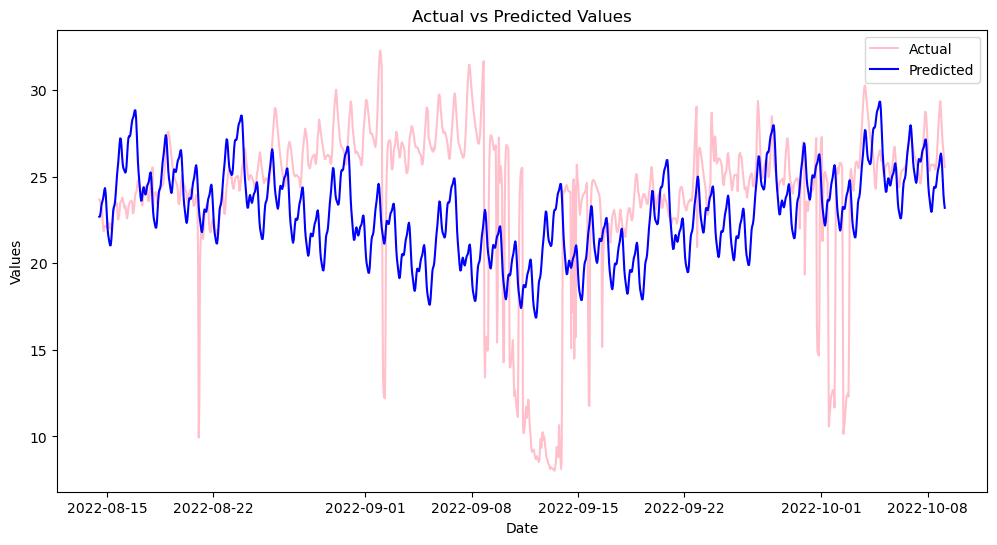

In [49]:

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the actual values in pink
plt.plot(test_df['ds'], y_test, label='Actual', color='pink')

# Plot the predicted values in blue
plt.plot(test_df['ds'], y_pred, label='Predicted', color='blue')

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')

# Add a legend to differentiate the actual and predicted values
plt.legend()

# Show the plot
plt.show()


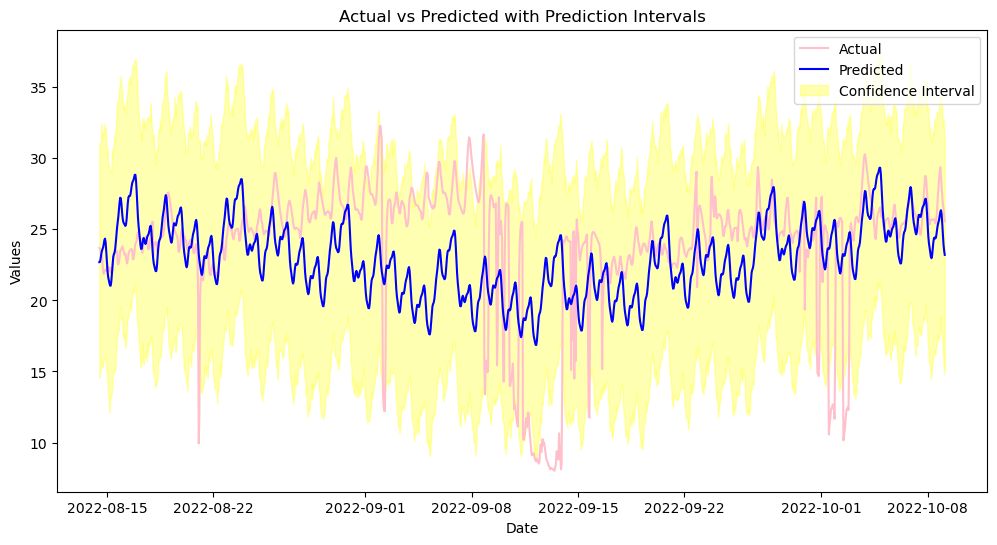

In [50]:

#Intervals plot 
#To show the uncertainty of predictions along with actual values.

plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_test, label='Actual', color='pink')
plt.plot(test_df['ds'], y_pred, label='Predicted', color='blue')

# Plot prediction intervals from forecast data
plt.fill_between(test_df['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='yellow', alpha=0.3, label='Confidence Interval')

plt.title('Actual vs Predicted with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


In [51]:
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-14 12:00:00,22.06,14.55,31.06,22.06,22.06,0.63,0.63,0.63,-0.21,...,-1.44,-1.44,-1.44,2.28,2.28,2.28,0.00,0.00,0.00,22.69
1,2022-08-14 13:00:00,22.06,14.91,30.74,22.06,22.06,0.65,0.65,0.65,-0.14,...,-1.50,-1.50,-1.50,2.29,2.29,2.29,0.00,0.00,0.00,22.70
2,2022-08-14 14:00:00,22.06,15.21,30.80,22.06,22.06,0.86,0.86,0.86,0.13,...,-1.56,-1.56,-1.56,2.29,2.29,2.29,0.00,0.00,0.00,22.92
3,2022-08-14 15:00:00,22.06,15.46,32.47,22.06,22.06,1.17,1.17,1.17,0.49,...,-1.62,-1.62,-1.62,2.30,2.30,2.30,0.00,0.00,0.00,23.23
4,2022-08-14 16:00:00,22.06,15.63,31.28,22.06,22.06,1.41,1.41,1.41,0.78,...,-1.68,-1.68,-1.68,2.31,2.31,2.31,0.00,0.00,0.00,23.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,2022-10-08 23:00:00,22.68,17.33,33.59,22.68,22.68,2.76,2.76,2.76,0.96,...,-0.88,-0.88,-0.88,2.67,2.67,2.67,0.00,0.00,0.00,25.44
1332,2022-10-09 00:00:00,22.68,16.42,32.19,22.68,22.68,1.96,1.96,1.96,0.18,...,-0.90,-0.90,-0.90,2.67,2.67,2.67,0.00,0.00,0.00,24.64
1333,2022-10-09 01:00:00,22.68,15.67,32.77,22.68,22.68,1.28,1.28,1.28,-0.48,...,-0.92,-0.92,-0.92,2.67,2.67,2.67,0.00,0.00,0.00,23.96
1334,2022-10-09 02:00:00,22.68,14.82,32.06,22.68,22.68,0.83,0.83,0.83,-0.90,...,-0.95,-0.95,-0.95,2.67,2.67,2.67,0.00,0.00,0.00,23.51


In [52]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Absolute Error: 3.67
Root Mean Squared Error: 4.88
R-squared: -0.14


In [53]:
# Assuming you have `y_test` and `y_pred` already defined
residuals = y_test - y_pred

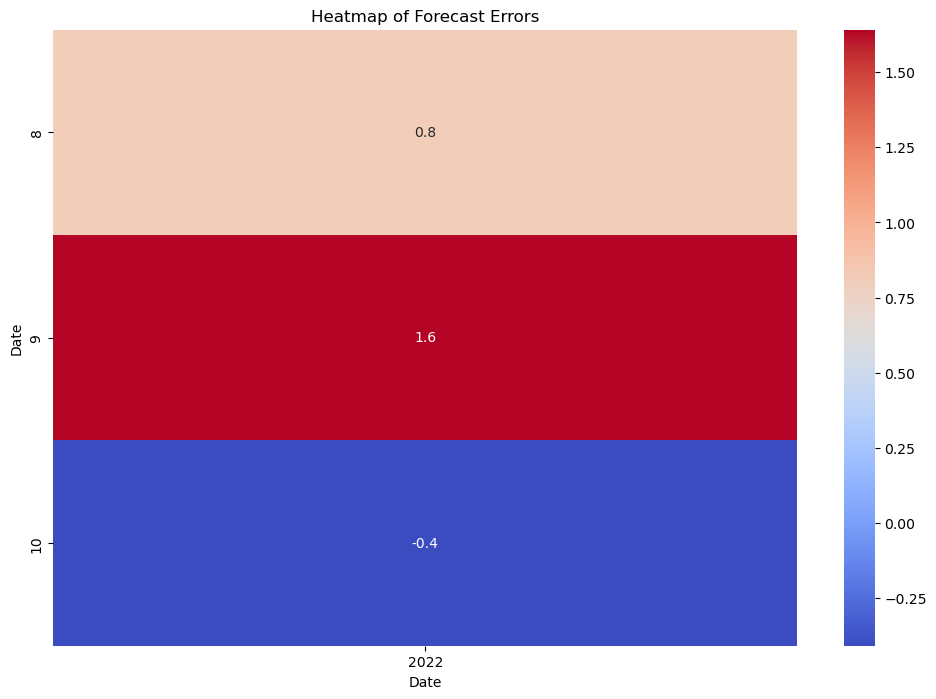

In [54]:
#heatmap 

# Create a DataFrame with errors and corresponding dates
errors_df = pd.DataFrame({
    'Date': test_df['ds'],
    'Error': residuals
})

# Pivot the DataFrame for heatmap
heatmap_data = errors_df.pivot_table(index=errors_df['Date'].dt.month, columns=errors_df['Date'].dt.year, values='Error')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Heatmap of Forecast Errors')
plt.show()


